### Los Engranajes de las Redes Neuronales: Operaciones con Tensores

**Nota:** No vamos a usar notación matemática algebráica de Tensores, dado que no es el objetivo de esta sección. Necesitamos su conocimiento conceptual y práctico

Cuando al princípio creabamos la RNA con la definición de una capa con el código:

```
keras.layer.Dense(512, activation='relu')
```

Esa capa se puede interpretar como una función:

``output = relu(dot(W, input) + b)``

Que toma un tensor 2D (``W``) al que le aplicamos el **producto escalar**  ``dot`` contra el tensor de entrada (``input``), que a su vez devuelve un tensor 2D que lo sumamos con un **vector** ``b`` y devuelve de nuevo un tensor 2D al que aplicamos la función ``relu.relu(x)`` que es max(x,0) lo cual devuelve un tensor 2D al ``output``

#### Operaciones elemento a elemento
- Suma y relu son elemento a elemento: Operaciones que se aplican de manera independiente a cada entrada de los tensores.
- Permiten implementaciones paralelas masivas

In [ ]:
def naive_relu(x):
    assert len(x.shape) == 2 # x es un tensor 2D Numpy
    x = x.copy() # Evita sobreescribir el tensor de entrada
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i, j], 0)
    return x

import numpy as np

x = np.array([[5, -78, 2, -34, 0],
              [6, -79, 3, -35, 1],
              [7, -80, 4, -36, 2]])


x.shape, x.shape[0], x.shape[1], naive_relu(x)

((3, 5), 3, 5, array([[5, 0, 2, 0, 0],
        [6, 0, 3, 0, 1],
        [7, 0, 4, 0, 2]]))

In [ ]:
# Solo soporta suma de tensores 2D con formas idénticas
def naive_add(x, y):
    assert len(x.shape) == 2 # x e y son tensores 2D Nimpy
    assert x.shape == y.shape
    x = x.copy() # Evita sobreescribir el tensor de entrada
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[i, j]
    return x

x = np.array([[5, 78, 2, 34, 0],
              [6, 79, 3, 35, 1],
              [7, 80, 4, 36, 2]])

y = np.array([[5, 78, 2, 34, 0],
              [6, 79, 3, 35, 1],
              [7, 80, 4, 36, 2]])

naive_add(x, y)

array([[ 10, 156,   4,  68,   0],
       [ 12, 158,   6,  70,   2],
       [ 14, 160,   8,  72,   4]])

Siguiendo el mismo proncípio, se pueden hacer, multiplicaciones, restas, etc, elemento a elemento. En la práctica, para el caso de matrices Numpy, estas operaciones ya están integradas y optimizadas en las **BLAS** (Basic Linear Algebra Subprograms) que están implementadas en Fortran o C.

In [ ]:
import time

x = np.random.random((20, 100))
y = np.random.random((20, 100))

t0 = time.time()
for _ in range(1000):
    z = x + y # Suma elemento a elemento
    z = np.maximum(z, 0.) # relu elemento a elemento
print("Took: {0:.2f} s".format(time.time() - t0))

Took: 0.01 s


Que es bastante más eficiente que:

In [ ]:
t0 = time.time()
for _ in range(1000):
    z = naive_add(x, y)
    z = naive_relu(z)
print("Took: {0:.2f} s".format(time.time() - t0))

Took: 2.67 s


#### Broadcasting
- El `naive_add` implementado antes solo soporta suma de tensores 2D con formas idénticas y en ``output = relu(dot(W, input) + b)`` sumamos un tensor 2D con un vector: Si no hay "ambigüedad" el tensor más pequeño se **expandirá** para coincidir con la forma del más grande. Esto es conocido como **broadcasting** y tiene 2 pasos:
  1. Se añaden **ejes broadcast** al tensor más pequeño para que coincida con el `ndim` del tensor más grande
  2. El tensor pequeño se **repite a lo largo de los nuevos ejes** para coincidir con la forma completa del tensor grande

In [ ]:
import numpy as np
# x tiene la forma (32,10)
x = np.random.random((32, 10))
# y tiene la forma (10,)
y = np.random.random((10,))
x, y

(array([[0.31694956, 0.4443569 , 0.67207668, 0.97029237, 0.37213644,
         0.34024142, 0.60475498, 0.07518493, 0.28599376, 0.23054122],
        [0.78106453, 0.31717006, 0.59247799, 0.6410915 , 0.1913802 ,
         0.67263727, 0.36078845, 0.08022667, 0.98617988, 0.13411872],
        [0.07590996, 0.05675749, 0.0778534 , 0.40161597, 0.85360222,
         0.68056203, 0.04814399, 0.32459117, 0.63352812, 0.36707664],
        [0.74224304, 0.31451547, 0.96974088, 0.04797153, 0.87217818,
         0.58809147, 0.74288529, 0.01094437, 0.81964618, 0.66823464],
        [0.96153305, 0.26086255, 0.08511175, 0.71774906, 0.23253944,
         0.4802278 , 0.04244688, 0.71873088, 0.64575751, 0.48520886],
        [0.47226463, 0.39078865, 0.73332342, 0.5297679 , 0.86467075,
         0.29959546, 0.95749654, 0.43498836, 0.78309871, 0.84197412],
        [0.92315426, 0.7450499 , 0.47899245, 0.96761538, 0.29472065,
         0.59824568, 0.0152718 , 0.90918736, 0.83128463, 0.31670263],
        [0.22611386, 0.6456

In [ ]:
# Añadimos un eje vacío a y
y = np.expand_dims(y, axis=0)
y.shape

(1, 10)

In [ ]:
# Repetimos y 32 vaces a lo largo de este nuevo eje. Así que acabamos
# con un tensor Y con la forma (32, 10), donde Y[i, :]==i en range(0, 32)
Y = np.concatenate([y] * 32, axis=0)
Y.shape

(32, 10)

In [ ]:
Y

array([[0.7882653 , 0.65895926, 0.85135237, 0.33048101, 0.82218908,
        0.55099704, 0.76017465, 0.93063392, 0.14507332, 0.71653295],
       [0.7882653 , 0.65895926, 0.85135237, 0.33048101, 0.82218908,
        0.55099704, 0.76017465, 0.93063392, 0.14507332, 0.71653295],
       [0.7882653 , 0.65895926, 0.85135237, 0.33048101, 0.82218908,
        0.55099704, 0.76017465, 0.93063392, 0.14507332, 0.71653295],
       [0.7882653 , 0.65895926, 0.85135237, 0.33048101, 0.82218908,
        0.55099704, 0.76017465, 0.93063392, 0.14507332, 0.71653295],
       [0.7882653 , 0.65895926, 0.85135237, 0.33048101, 0.82218908,
        0.55099704, 0.76017465, 0.93063392, 0.14507332, 0.71653295],
       [0.7882653 , 0.65895926, 0.85135237, 0.33048101, 0.82218908,
        0.55099704, 0.76017465, 0.93063392, 0.14507332, 0.71653295],
       [0.7882653 , 0.65895926, 0.85135237, 0.33048101, 0.82218908,
        0.55099704, 0.76017465, 0.93063392, 0.14507332, 0.71653295],
       [0.7882653 , 0.65895926, 0.8513523

In [ ]:
Y[0]

array([0.7882653 , 0.65895926, 0.85135237, 0.33048101, 0.82218908,
       0.55099704, 0.76017465, 0.93063392, 0.14507332, 0.71653295])

In [ ]:
def naive_add_matrix_and_vector(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[j]
    return x

# x tiene la forma (32,10)
x = np.random.random((32, 10))
# y tiene la forma (10,)
y = np.random.random((10,))
x, y, naive_add_matrix_and_vector(x, y)

(array([[1.42253572e-01, 5.45923104e-01, 5.85925050e-02, 8.21225168e-02,
         2.17174551e-01, 1.30055887e-01, 9.74953098e-01, 7.66076654e-01,
         7.65574012e-01, 2.09099837e-01],
        [3.52762855e-01, 4.12007926e-01, 2.77151222e-01, 7.66665203e-01,
         1.45179481e-01, 1.80737186e-02, 4.14135484e-01, 6.29547044e-01,
         9.36627220e-01, 9.89455617e-01],
        [2.70379105e-01, 6.51052044e-01, 7.92349996e-01, 2.19276637e-01,
         3.04395683e-01, 4.67487998e-01, 8.67125224e-01, 2.52691768e-01,
         1.74905384e-01, 3.57727135e-01],
        [8.97145412e-01, 7.23212860e-01, 4.99110625e-01, 8.09320654e-01,
         2.85501640e-01, 1.12984663e-01, 9.14199184e-01, 1.04732605e-01,
         4.83850857e-01, 9.79790475e-01],
        [5.40002818e-01, 7.35097454e-01, 8.57826746e-01, 8.16917043e-03,
         1.80265404e-01, 4.54903818e-02, 2.02323863e-01, 3.47696442e-01,
         5.37262593e-01, 9.34172522e-01],
        [8.64316776e-01, 9.43088296e-01, 7.58591159e-01, 5.8

Broadcasting se puede aplicar a dos tensores si uno tiene la forma `(a, b, ... n, n+1, ... m)` y el otro `(n, n+1, ... m)`. El broadcasting se producirá automáticamente para los ejes `a` hasta `n-1`

In [ ]:
# Ejemplo aplicación operación maximun elemento a elemento a dos tensores
# de distinta forma mediante broadcasting
import numpy as np
x = np.random.random((64, 3, 32, 10))
y = np.random.random((32, 10))
# El resultado z tendrá forma (64, 3, 32, 10), como x
z = np.maximum(x, y)
z.shape

(64, 3, 32, 10)

#### Producto Tensorial
- Producto Tensorial `dot` (en Numpy y Keras, sintaxis diferente en TensorFlow) **no** es un producto elemento a elemento (que también existe y lo hemos visto antes). Es la operación de tensores más útil y habitual.
- Producto elemento a elemento se hace con `*` en Numpy, Keras, Theano y TensorFlow

In [ ]:
import numpy as np
x = np.random.random((32,))
y = np.random.random((32,))
z = np.dot(x, y)
x, y, z

(array([0.80331742, 0.08301847, 0.28970148, 0.15139844, 0.66140821,
        0.70877123, 0.23431416, 0.6676432 , 0.18319647, 0.03135185,
        0.65078451, 0.72107716, 0.27321735, 0.90126042, 0.23870571,
        0.08881234, 0.35361387, 0.40642847, 0.33208002, 0.49741959,
        0.11848556, 0.99106853, 0.61811642, 0.63400737, 0.70905761,
        0.81163506, 0.99990388, 0.9256389 , 0.92435157, 0.52284066,
        0.6121957 , 0.07538974]),
 array([0.49806474, 0.10107906, 0.26821299, 0.60942732, 0.29183036,
        0.50344264, 0.39836897, 0.81848746, 0.94815133, 0.32760218,
        0.8073338 , 0.20977269, 0.53085714, 0.45429106, 0.54339182,
        0.72072398, 0.25366484, 0.39449332, 0.21337446, 0.98880301,
        0.32901733, 0.15167068, 0.11541295, 0.13658685, 0.96483821,
        0.13089386, 0.50401561, 0.20142777, 0.7140142 , 0.14063116,
        0.75159152, 0.59214803]),
 7.255981635775929)

Vamos a ver que operación hace por dentro:

In [ ]:
# Para el caso de dos vectores
def naive_vector_dot(x, y):
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]
    z = 0.
    # Como podemos ver es el producto escalar con lo que solo
    # se puede hacer con vectores con el mismo número de elementos
    for i in range(x.shape[0]):
        z += x[i] * y[i]
    return z
naive_vector_dot(x, y)

7.255981635775928

También lo podemos aplicar a una matrix `x` pro un vector `y` que devuelve un vector que son los productos escalares entre `y` y las filas de `x`

In [ ]:
def naive_matrix_vector_dot(x, y):
    assert len(x.shape) == 2 # x es una matriz Numpy
    assert len(y.shape) == 1 # y es un vector Numpy
    assert x.shape[1] == y.shape[0] # La dimensión 1 de x debe
    # ser la misma que la dimensión 0 de y
    z = np.zeros(x.shape[0]) # Esta operación devuelve un vector
    # ceros con la forma de y
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i] += x[i, j] * y[j]
    return z
# x tiene la forma (32,10)
x = np.random.random((32, 10))
# y tiene la forma (10,)
y = np.random.random((10,))
naive_matrix_vector_dot(x,y)

array([3.28072807, 3.47112554, 2.7090506 , 2.88555528, 3.0359528 ,
       2.66841845, 2.19649081, 2.17668928, 1.8115342 , 3.49862924,
       2.78274975, 2.98192663, 2.96724339, 3.36948228, 3.25871547,
       2.79262622, 2.61373459, 2.6924787 , 2.82945045, 3.2132063 ,
       3.07605179, 3.5565939 , 2.30090655, 3.20418236, 3.00539401,
       2.8556602 , 2.8285636 , 3.97205533, 3.5474591 , 2.71167064,
       2.80640632, 3.00405453])

Podríamos haber reutilizado en código de `naive_vector_dot`

In [ ]:
def naive_matrix_vector_dot(x, y):
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        z[i] = naive_vector_dot(x[i, :], y)
    return z
naive_matrix_vector_dot(x,y)

array([3.28072807, 3.47112554, 2.7090506 , 2.88555528, 3.0359528 ,
       2.66841845, 2.19649081, 2.17668928, 1.8115342 , 3.49862924,
       2.78274975, 2.98192663, 2.96724339, 3.36948228, 3.25871547,
       2.79262622, 2.61373459, 2.6924787 , 2.82945045, 3.2132063 ,
       3.07605179, 3.5565939 , 2.30090655, 3.20418236, 3.00539401,
       2.8556602 , 2.8285636 , 3.97205533, 3.5474591 , 2.71167064,
       2.80640632, 3.00405453])

Cuestiones a tener en cuenta:
- En cuanto uno de los dos tensores tienen un `ndim` mayor que 1, `dot` ya no es simétrica, con lo que `dot(x, y)` es distinto que `dot(y,x)`
- Aplicación habitual: **Producto escalar** de **dos matrices** (`dot(x,y)` si, y solo si, `x.shape[1] == x.shape[0]`). El resultado sería una matriz con la forma `(x.shape[0], y.shape[1])` y los coeficientes son los **productos vectoriales** entre las **filas de `x`** y las **columnas de `y`**

In [ ]:
def naive_matrix_dot(x, y):
    assert len(x.shape) == 2 # x es matriz Numpy
    assert len(y.shape) == 2 # y es matriz Numpy
    assert x.shape[1] == y.shape[0] # La dimensión 1 de x
    # debe ser igual que la dimensión 0 de y
    z = np.zeros((x.shape[0], y.shape[1])) # Esta operación devuelve una
    # matriz de ceros con una forma específica
    for i in range(x.shape[0]): # Itera por las filas de x
        for j in range(y.shape[1]): # ....y por las columnas de y
            row_x = x[i, :]
            column_y = y[:, j]
            z[i, j] = naive_vector_dot(row_x, column_y)
    return z
# x tiene la forma (10,5)
x = np.random.random((10, 5))
# y tiene la forma (8,10)
y = np.random.random((5,8))
# Me devolverá una Matriz (10, 8)
naive_matrix_dot(x, y)

array([[1.08398629, 1.67545504, 1.65930864, 1.52491624, 2.42257223,
        2.12232402, 1.53628376, 1.64825927],
       [1.69581174, 1.23486228, 1.85538095, 1.36906266, 2.20955754,
        1.66966206, 1.18704986, 2.02087441],
       [1.34275096, 1.36814106, 1.5678455 , 1.15969438, 1.63673763,
        2.19554948, 1.27843166, 1.80272618],
       [1.01173387, 0.67948473, 0.72689956, 0.80591408, 1.38313513,
        1.05481697, 0.72994755, 1.30014791],
       [1.22414615, 1.65915144, 1.67109123, 1.36552458, 2.19171478,
        2.2716643 , 1.30991111, 1.55428986],
       [1.68666594, 1.38811943, 2.11401823, 1.32835989, 2.09988088,
        1.86847049, 1.11570627, 1.84271145],
       [1.37257951, 0.93681851, 1.62927157, 1.14636641, 1.57679126,
        1.37370786, 1.22859531, 1.95096367],
       [1.6705252 , 1.17330695, 1.91430423, 1.40564022, 2.208183  ,
        1.52306835, 1.2648918 , 2.09956111],
       [1.68235005, 1.26761354, 1.88975342, 1.42419123, 2.23978989,
        1.71986915, 1.304818

`x`, `y` y `z` se representan como rectángulos

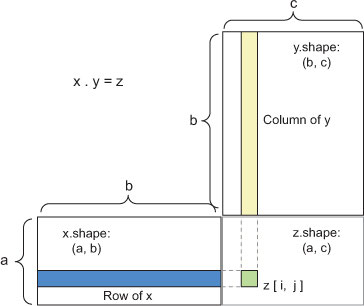

#### Cambiar la forma de tensores
- Esto es muy importante, porque lo vamos a usar mucho. No le hemos usado en las capas `Dense` de nuestro ejemplo, pero si al **procesar los datos de dígitos** antes de introducirlos a nuestra red.

`train_images = train_images.reshape((60000, 28 * 28))`

- Cambiar la forma de un tensor es reorganizar sus filas y columnas para que se ajusten a una nueva forma. El tensor resultado tiene el mísmo número de coeficientes que el original:

In [ ]:
x = np.array([[0., 1.],
             [2., 3.],
             [4., 5.]])
x, x.shape

(array([[0., 1.],
        [2., 3.],
        [4., 5.]]), (3, 2))

In [ ]:
x = x.reshape((6, 1))
x, x.shape

(array([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.]]), (6, 1))

In [ ]:
x = x.reshape((2, 3))
x, x.shape

(array([[0., 1., 2.],
        [3., 4., 5.]]), (2, 3))

In [ ]:
# Caso especial de cambio de forma es la Transposición
# Que, como bien sabéis, es cambiar filas por columnas
# con lo que x[i,:] se convierte en x[:,i]
x = np.zeros((300, 20))
y = np.transpose(x)
x.shape, y.shape

((300, 20), (20, 300))

#### Interpretación Geométrica de las Operaciones con Tensores
Le damos una interpretación geométrica basándonos en que los tensores son coordenadas de puntos en un espacio.
- Por ejemplo, para el vector ``A[0.5, 1]``

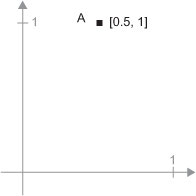

- El vector suele representarse con una flecha desde el origen:

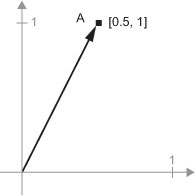

- Consideramos ahora el vector `B=[1, 0.25]` y lo sumamos en suma vectorial tradicional

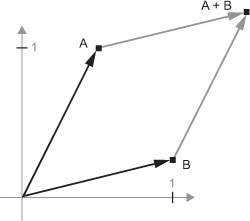

- Las operaciones geométricas elementales, como las transformaciones afines, las rotaciones, escaladas, etc, se pueden expresar como operaciones con tensores. Ejemplo: **Rotación** de un vector 2D en un ángulo **theta** a través de un **producto escalar** con una matriz de 2 x 2 `R=[u, v]`, donde `u` y `v` son dos vectores del plano: `u = [cos(theta), sin(theta)]` y `v = [-sin(theta), cos(theta)]`

#### Interpretación Geométrica del Deep Learning

Repasando:
- Las RNA consisten en:
  - Cadenas de **operaciones de tensores**
  - Esas operaciones son solo **transformaciones geométricas** de los **datos de entrada**

Solo que son **transformaciones geométricas muy complejas** en un espacio **muy dimensional**, implementada a través de **largas series** de **pasos simples**

Imaginarlo con el ejemplo de las dos hojas de papel de colores azul y roja, una encima de la otra, y arrugadas juntas en una bolita.
- La bola arrugada son nuestros datos de entrada
- Cada hoja es una clase de datos en nuestro problema de clasificación
- La red neuronal, en este caso, u otro algoritmo de machine learning, idea una transformación para que la bola deje de estar arrugada y las dos hojas puedan separarse limpiamente.
  - Con DL seria una serie de transformaciones simples del espacio 3D (lo que hacemos con los dedos, con un movimiento cada vez)


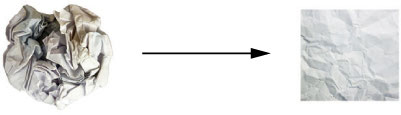

---